   laser_distance_id                   timestamp  device_id     value  \
0           78862992  2025-11-28 12:10:01.520000          7 -332298.0   
1           78862993  2025-11-28 12:10:01.522000          7 -332262.0   
2           78862994  2025-11-28 12:10:01.522000          7 -332262.0   
3           78862995  2025-11-28 12:10:01.522000          7 -332398.0   
4           78862996  2025-11-28 12:10:01.522000          7 -332590.0   

   machine_id  sampling_frequency  param_id  
0           1                   1       353  
1           1                   1       353  
2           1                   1       353  
3           1                   1       353  
4           1                   1       353  


C:\Users\yusei\AppData\Local\Temp\ipykernel_32944\878418346.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['value'] = subset_data['value'] / 10
C:\Users\yusei\AppData\Local\Temp\ipykernel_32944\878418346.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['value'] = subset_data['value'].apply(lambda x: x if -40000 <= x <= 40000 else None)


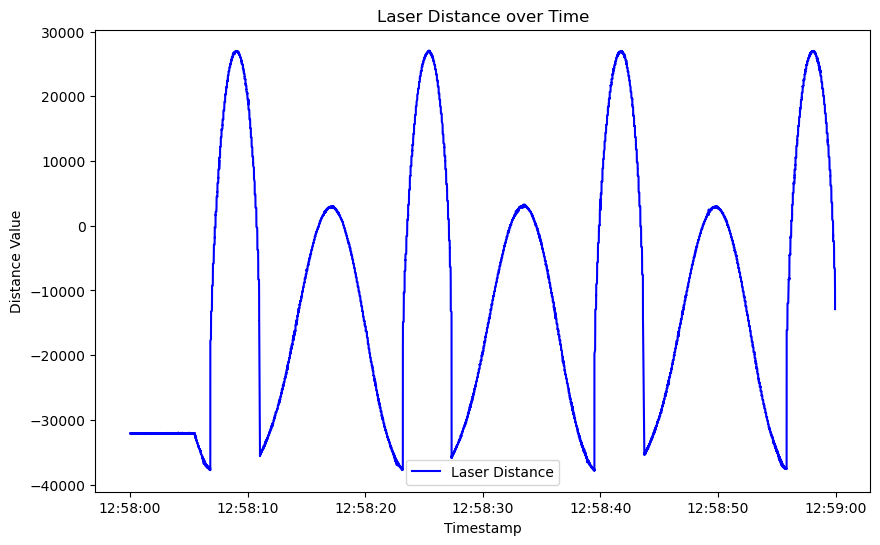

In [5]:
#读取data\origin_data\1121\laser_distance.csv文件，并根据其timestamp列和value列可视化数据
import pandas as pd
import matplotlib.pyplot as plt
import os
# 读取CSV文件
file_path = r"C:\\Users\\yusei\\Workspace\\异常检测\\MSCRED\\data\\origin_data\\1128_send\\laser_distance.csv"
data = pd.read_csv(file_path)
# 检查数据结构
print(data.head())
# 确保timestamp列为datetime格式
data['timestamp'] = pd.to_datetime(data['timestamp'])

#截取部分数据进行可视化，根据时间截取
start_time = pd.to_datetime("2025-11-28 12:58:00")
end_time = pd.to_datetime("2025-11-28 12:59:00")
subset_data = data[(data['timestamp'] >= start_time) & (data['timestamp'] <= end_time)]

#对value列进行处理，value数值整体除以10
subset_data['value'] = subset_data['value'] / 10

#对value列进行处理，超出-40000到40000范围的值设为NaN
subset_data['value'] = subset_data['value'].apply(lambda x: x if -40000 <= x <= 40000 else None)

# 可视化数据
plt.figure(figsize=(10, 6))
plt.plot(subset_data['timestamp'], subset_data['value'], label='Laser Distance', color='blue')
plt.xlabel('Timestamp')
plt.ylabel('Distance Value')
plt.title('Laser Distance over Time')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks

def process_laser_data(file_path, output_path):
    # 1. 读取数据
    # 假设CSV只有两列，或者你需要根据实际情况指定列名
    print("正在读取数据...")
    df = pd.read_csv(file_path)
    
    # 确保时间列是datetime格式
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # 2. 数据清洗：处理设备异常导致的越界数据 (-40000, 40000)
    # 将超出范围的数据设为 NaN
    mask_outlier = (df['value'] <= -40000) | (df['value'] >= 40000)
    df.loc[mask_outlier, 'value'] = np.nan
    
    # 对 NaN 进行插值处理，保证信号连续以便于寻找峰值
    # 如果数据量很大，可以用 'linear' 插值
    df['value_interp'] = df['value'].interpolate(method='linear')
    
    # 3. 信号平滑 (可选，但推荐)
    # 原始激光数据通常有噪声，使用滑动平均可以让峰值检测更准确
    # window大小根据采样频率调整，假设数据比较密，取 20-50 个点做平滑
    df['value_smooth'] = df['value_interp'].rolling(window=50, center=True).mean()
    
    # 填充滑动平均产生的空值
    df['value_smooth'] = df['value_smooth'].fillna(method='bfill').fillna(method='ffill')

    # 4. 峰值检测
    # distance: 两个峰值之间的最小水平距离（防止检测到双峰）
    # height: 峰值的最小高度，看图大峰在25000左右，小峰在3000左右，这里设个较低的阈值
    peaks_indices, properties = find_peaks(df['value_smooth'], distance=2000, height=1000)
    
    # 获取峰值的时间和数值
    peak_times = df.loc[peaks_indices, 'timestamp'].values
    peak_values = df.loc[peaks_indices, 'value_smooth'].values
    
    # 5. 区分大波峰和小波峰
    # 根据图中观察：大波峰 > 15000 (大概值)，小波峰 < 15000
    # 也可以用 KMeans 聚类自动区分，这里用简单阈值法
    # 你可能需要根据实际数据的数值范围微调这个 THRESHOLD
    THRESHOLD_LARGE = 15000 
    
    # 创建一个用于存储结果的时间序列，索引与原始数据相同
    df['equivalent_spacing'] = np.nan
    
    print(f"检测到 {len(peak_values)} 个峰值，正在进行配对计算...")

    # 6. 遍历峰值进行配对和计算
    # 逻辑：只要相邻的两个峰值满足 "一大一小" 的交替规律，就计算并填充
    for i in range(len(peak_values) - 1):
        current_val = peak_values[i]
        next_val = peak_values[i+1]
        
        current_time = peak_times[i]
        next_time = peak_times[i+1]
        
        # 判断类型
        is_curr_large = current_val > THRESHOLD_LARGE
        is_next_large = next_val > THRESHOLD_LARGE
        
        # 核心判断：只有当两个峰值类型不同（一大一小 或 一小一大）时才计算
        # 这样可以防止连续检测到两个大波峰（漏检小波峰）时算出错误数据
        if is_curr_large != is_next_large:
            # 计算绝对差值
            diff = abs(current_val - next_val)
            
            # 填充这段时间区间
            # mask_time = (df['timestamp'] >= current_time) & (df['timestamp'] <= next_time)
            # df.loc[mask_time, 'equivalent_spacing'] = diff
            # 只填充从当前峰值时间点开始到下一个峰值时间点之前的所有时间点，承认延迟，即结果向右平移，覆盖式填充
            mask_future = (df['timestamp'] >= next_time)
            df.loc[mask_future, 'equivalent_spacing'] = diff
        else:
            # 如果连续出现两个大波峰或两个小波峰，说明中间可能有漏检或异常，这段时间跳过不填充
            pass

    # 7. 重采样 (Resample) 到 1s 一个点
    print("正在进行降采样 (1Hz)...")
    
    # 设置时间为索引
    df_result = df.set_index('timestamp')
    
    # 按1秒重采样。
    # 这里使用 mean() 是为了取该秒内的平均状态，或者用 max() / first() 也可以
    # 由于我们是填充满了时间段，mean() 是比较稳妥的
    resampled_df = df_result[['equivalent_spacing']].resample('1S').mean()
    
    # 如果你也想要保留原始的 value 均值，可以把 value 加进去：
    # resampled_df = df_result[['value', 'equivalent_spacing']].resample('1S').mean()

    # 8. 保存结果
    # 可能会有一些时间段没有大-小波峰交替（比如开头或结尾），这些地方会是 NaN
    #对于开头所有的Nan值，填充为第一个有效值。其他段落内的空值保持不变
    first_valid_index = resampled_df['equivalent_spacing'].first_valid_index()
    if first_valid_index is not None:
        first_valid_value = resampled_df.loc[first_valid_index, 'equivalent_spacing']
        # resampled_df['equivalent_spacing'] = resampled_df['equivalent_spacing'].fillna(method='bfill', limit=None)
        resampled_df.loc[:first_valid_index, 'equivalent_spacing'] = first_valid_value
    # 如果需要填充空值（例如保持上一次的值），可以取消下面这行的注释：
    # resampled_df['equivalent_spacing'] = resampled_df['equivalent_spacing'].ffill()

    #将列名equivalent_spacing改为value
    resampled_df = resampled_df.rename(columns={'equivalent_spacing': 'value'})
    resampled_df.to_csv(output_path)
    print(f"处理完成，结果已保存至: {output_path}")

# --- 执行配置 ---
if __name__ == "__main__":
    # 请修改这里的输入和输出文件名
    INPUT_FILE = 'C:\\Users\\yusei\\Workspace\\异常检测\\MSCRED\\data\\origin_data\\1121\\laser_distance.csv'
    OUTPUT_FILE = 'C:\\Users\\yusei\\Workspace\\异常检测\\MSCRED\\data\\origin_data\\1121\\0_processed_spacing_1s.csv'
    
    try:
        process_laser_data(INPUT_FILE, OUTPUT_FILE)
    except FileNotFoundError:
        print(f"错误：找不到文件 {INPUT_FILE}，请确保文件在当前目录下。")
    except Exception as e:
        print(f"发生错误: {e}")

正在读取数据...
检测到 1519 个峰值，正在进行配对计算...
正在进行降采样 (1Hz)...
处理完成，结果已保存至: C:\Users\yusei\Workspace\异常检测\MSCRED\data\origin_data\1121\0_processed_spacing_1s.csv
